The example shows how to do basic data analysis of the datasets. The example uses 2021 Fairfax County Virginia traffic stop data to analyze race/ethnicity values.

In [1]:
try:
    import openpolicedata as opd
except:
    import sys
    sys.path.append('../openpolicedata')
    import openpolicedata as opd
import pandas as pd
import numpy as np

In [2]:
agency_comp = "Fairfax County Police Department"
year = 2021
src = opd.Source(source_name="Virginia")
t_ffx = src.load_from_url(year=year, table_type='STOPS', agency=agency_comp)

# Make a copy of the table so that we can make changes without changing the original table.
df_ffx = t_ffx.table.copy()

# Race and ethnicity are saved in different columns in Virginia's data but analysis is typically done on a combined race/ethnicity column
# containing Hispanic of all races, White Non-Hispanic, Black Non-Hispanic, Asian Non-Hispanic, etc. groups.
# Create combined race/ethnicity category
df_ffx["race_eth"] = df_ffx["race"]   # Default the value of the race/ethnicity to the race

# For all rows where the ethnicity is HISPANIC, set "race_eth" column to HISPANIC
df_ffx.loc[df_ffx["ethnicity"] == "HISPANIC", "race_eth"] = "HISPANIC"
# For all rows where the ethnicity is UNKNOWN, set "race_eth" column to UNKNOWN
df_ffx.loc[df_ffx["ethnicity"] == "UNKNOWN", "race_eth"] = "UNKNOWN"

# Find the number of searches of persons by race and ethnicity
# groupby groups the rows of the table based on ["person_searched","race_eth"]
# size() finds the number of rows in each group (i.e. the number of searches for each race/ethnicity group)
# unstack just makes the resulting table more presentable
searches = df_ffx.groupby(["person_searched","race_eth"]).size().unstack("race_eth")

searches

race_eth,AMERICAN INDIAN,ASIAN/PACIFIC ISLANDER,BLACK OR AFRICAN AMERICAN,HISPANIC,UNKNOWN,WHITE
person_searched,,,,,,
NO,88,1557,3574,4001,3291,8157
YES,1,57,338,513,12,346


Let's find the percent of stops that end in the person being searched for each race/ethnicity group

In [3]:
# The total number of searches for each group is the sum of each column
number_of_stops = searches.sum()
# The number of searches for each group is the number of Yes's for each group
number_of_searches = searches.loc["YES"]

# Calculate the search rate (% of people search over total people stopped)
percent_stops_with_search = np.round(number_of_searches/number_of_stops*100,1)

# Create a DataFrame out of the 3 metrics calculated above
searches_df = pd.DataFrame([number_of_stops, number_of_searches, percent_stops_with_search], 
    index=["# of Stops", "# of Searches", "% of Stops With Search"])
searches_df = searches_df.transpose()
searches_df["# of Stops"] = searches_df["# of Stops"].astype(int)
searches_df["# of Searches"] = searches_df["# of Searches"].astype(int)
# searches.dropna(inplace=True)
searches_df

,# of Stops,# of Searches,% of Stops With Search
race_eth,,,
AMERICAN INDIAN,89,1,1.1
ASIAN/PACIFIC ISLANDER,1614,57,3.5
BLACK OR AFRICAN AMERICAN,3912,338,8.6
HISPANIC,4514,513,11.4
UNKNOWN,3303,12,0.4
WHITE,8503,346,4.1


Text(0.5, 1.0, 'Percentage of Stops Where the Person is Searched')

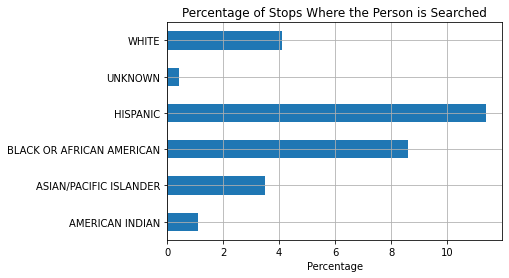

In [4]:
ax = searches_df.plot.barh(y="% of Stops With Search", grid=True, legend=False)
ax.set_ylabel("")
ax.set_xlabel("Percentage")
ax.set_title("Percentage of Stops Where the Person is Searched")